<div class="alert alert-info">
    <h1 align="center">WiDS Workshop October 2023</h1>
    <h3 align="center">Build Your Own AI Chatbot with GPT!</h3>
    <h5 align="center"><a href="https://www.linkedin.com/in/prasasthy-kb/">Prasasthy Balasubramanian</a></h5>
</div>

##  Objectives
- Designing, Developing, and Deploying custom Chatbots: Learn to design, develop, and deploy chatbots.
- Exploring GPT-3.5 Turbo: Explore the capabilities of GPT-3.5 Turbo.
- Utilizing Hugging Face Gradio to Launch Your Bot in Less Than 10 Minutes: Discover how to use Hugging Face Gradio for a chatbot launch in under 10 minutes.
- Overcoming Development Challenges: Address and overcome common development challenges.
- Importance of ethical considerations for building chatbots.

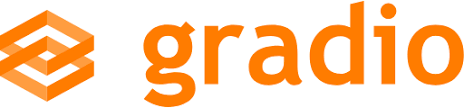 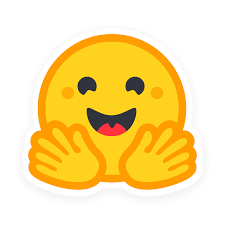 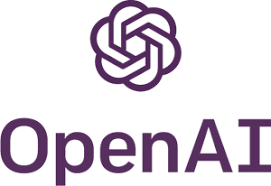

## Step2 : Customize your bot
Customize your bot with a functionality specific to your domain. Integrate with any other LLM's for the functionality execution.
Tailor your chatbot to perform specific tasks or answer domain-specific questions. Integrating with Language Models (LLMs) like GPT-3 for enhanced conversational capabilities
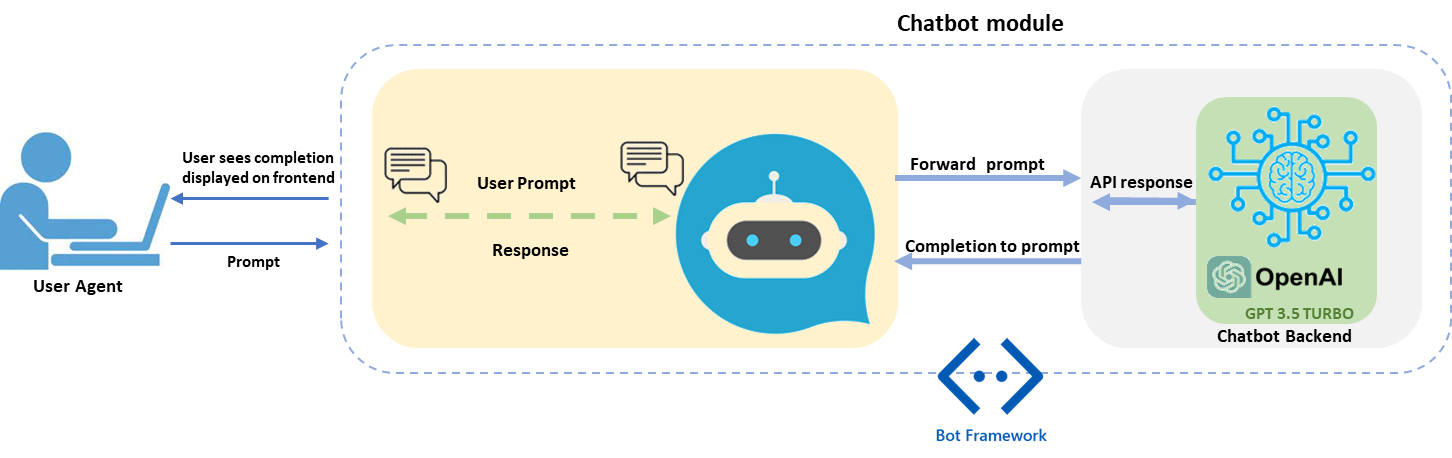.

In [1]:
import gradio as gr
import openai
import random
import time
import re

In [2]:
# Set up OpenAI API key
openai.api_key = "Your openAI API key"

In [3]:
messages=[
    {'role': 'system', 'content': 'You are an AI-powered cybersecurity agent called SPAMdetect Agent. Your primary goal is to provide valuable cybersecurity information to the user. Your task is to identify spam text data. Instruct the user to put the text need to be detected in "" for spam detection'}
]

In [4]:
import tensorflow_hub as hub
import pandas as pd
import tensorflow_text as text
import numpy as np
# downloading preprocessing files and model
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')
from tensorflow.keras.models import load_model, Model
import tensorflow as tf
model = tf.keras.models.load_model(
       ('model/bert_spam.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

2023-10-21 00:29:05.200927: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-21 00:29:05.303258: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-21 00:29:05.304932: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-21 00:29:06.584806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
def predict_model_forbot(input_message):
    return np.where(model.predict(input_message)>0.5,'spam', 'not spam')[0][0]
    
def scan_message(asking_message):
    # Regular expression pattern to find quoted sentences or phrases
    pattern = r'"(.*?)"|\'(.*?)\''

    # Use re.findall to find all quoted sentences in the input string
    quoted_sentences = re.findall(pattern, asking_message)

    # Filter out empty strings from the matched groups
    quoted_sentences = [group[0] if group[0] else group[1] for group in quoted_sentences]
    sentence = ""
    if quoted_sentences:
        for sentence in quoted_sentences:
           response_out = predict_model_forbot([sentence])
    else:
        response_out = None
    return response_out, sentence

In [6]:
def user( history, text ):
    history = history + [(text, None)]
    return history, gr.update(value="", interactive=False)
        
def bot(history):
    asking_message = history[-1][0]
    response_out, sentence = scan_message(asking_message)
    if response_out == None:
        response_message = use_gpt(asking_message)
        history[-1][1] = ""
        for character in response_message:
            history[-1][1] += character
            time.sleep(0.05)
            yield history
    else:
        response_message = "The text you provided, '" + sentence + "' appears to be " + response_out
        history[-1][1] = ""
        for character in response_message:
            history[-1][1] += character
            time.sleep(0.05)
            yield history

def use_gpt(message):
    messages.append({"role": "user", "content": message})
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages
    )
    ChatGPT_reply = response["choices"][0]["message"]["content"]
    messages.append({"role": "assistant", "content": ChatGPT_reply})
    return ChatGPT_reply

In [7]:
with gr.Blocks() as demo:
    chatbot = gr.Chatbot([], elem_id="chatbot")
    with gr.Row():
        with gr.Column():
            txt = gr.Textbox(
                show_label=False,
                placeholder="Enter text and press enter, or upload an image",
            )

    txt_msg =txt.submit(user, [chatbot, txt], [chatbot, txt], queue=False).then(
        bot, chatbot, chatbot
    )
    txt_msg.then(lambda: gr.update(interactive=True), None, [txt], queue=False)

demo.queue()
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
